In [44]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### PDF 문서 검색 Retrieval Chain 생성

In [45]:
from rag.pdf import PDFRetrievalChain


# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

In [46]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 검색하는 검색 도구 생성
retriever_tool = create_retriever_tool(        
    pdf_retriever,
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

tools = [retriever_tool]        # 문서 검색 도구를 리스트에 추가. 에이전트에서 사용가능하게 한다.

In [47]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from typing import Annotated, Sequence, TypedDict
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import BaseMessage


from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from langchain import hub

In [48]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [49]:
def agent(state: AgentState):           # 에이전트 노드

    messages = state["messages"]

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm = llm.bind_tools(tools)         # 문서 검색 도구 바인딩     

    response = llm.invoke(messages)     # llm을 실행해서 agent 답변을 가져온다

    return {"messages": [response]}     # 리스트로 답변을 만든다

In [50]:
class Grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

In [51]:
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:       # 사용자 질문과 문서 관련성 평가
 
    messages = state["messages"]
    
    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm_with_tool = model.with_structured_output(Grade)


    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    score = scored_result.binary_score

    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"
    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        return "rewrite"

In [52]:
def rewrite(state: AgentState):                 # 질문 재작성 노드

    messages = state["messages"]

    question = messages[0].content              # 원래 질문 추출

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문 개선
    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )
    
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    return {"messages": [response]}             # 재작성 된 질문 리턴

In [53]:
def generate(state):                        # 답변 생성 노드
    
    messages = state["messages"]        

    question = messages[0].content          # 원래 질문

    docs = messages[-1].content             # 가장 최근 메시지

    # prompt = hub.pull("teddynote/rag-prompt")
    
    prompt = PromptTemplate(
        input_variables=['context', 'question'],
        template="""You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
        Your primary mission is to answer questions based on provided context or chat history.
        Ensure your response is concise and directly addresses the question without any additional narration.

        ###

        Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

        # Steps

        1. Carefully read and understand the context provided.
        2. Identify the key information related to the question within the context.
        3. Formulate a concise answer based on the relevant information.
        4. Ensure your final answer directly addresses the question.
        5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

        # Output Format:
        [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

        **Source**(Optional)
        - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
        - (list more if there are multiple sources)
        - ...

        ###

        Remember:
        - It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
        - DO NOT use any external knowledge or information not present in the given materials.
        - If you can't find the source of the answer, you should answer that you don't know.

        ###

        # Here is the user's QUESTION that you should answer:
        {question}

        # Here is the CONTEXT that you should use to answer the question:
        {context}

        # Your final ANSWER to the user's QUESTION:"""
        )
    

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [54]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [55]:
######### 1. 그래프 생성 #########

workflow = StateGraph(AgentState)

In [56]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node("agent", agent)       # 에이전트 노드

retrieve = ToolNode([retriever_tool])       
workflow.add_node("retrieve", retrieve) # 검색 노드

workflow.add_node("rewrite", rewrite)   # 질문 재작성 노드
workflow.add_node("generate", generate) # 관련 문서 확인 후 응답 생성 노드

In [57]:
######### 3. 그래프 엣지(Edge) 추가  #########

# 엣지 연결
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,                     # 에이전트 결정 평가
    {                                            
        "tools": "retrieve",             # 조건 출력을 그래프 노드에 매핑   
        END: END,
    },
)

workflow.add_conditional_edges(          # 액션 노드 실행 후 처리될 엣지 정의
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

In [58]:
######### 6. 그래프 컴파일(compile)  #########

graph = workflow.compile(checkpointer=MemorySaver())

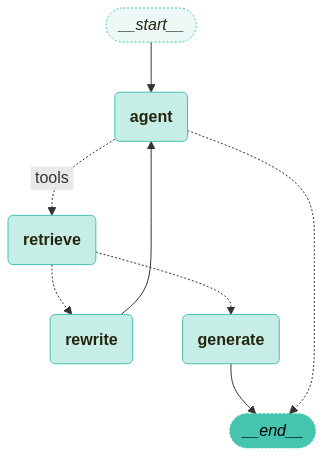

In [59]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}


i = 1

for event in graph.stream(inputs, config=config, stream_mode="updates"):

    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in event.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")

        if state_key == 'agent':
            print('------------------------------')
            print(f"🔄 [Node] 에이전트 노드 🔄")
            print(f"{state_value['messages']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['messages']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['messages']}")
            print('------------------------------')
            print()
        elif state_key == 'rewrite':
            print('------------------------------')
            print(f"🔄 [Node] 질문 재작성 노드 🔄")
            print(f"{state_value['  ']}")
            print('------------------------------')
            print()
            
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['messages']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : agent
------------------------------
🔄 [Node] 에이전트 노드 🔄
[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_I7NvkFiAwacfUVmtEtxLZYIn', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac'}, id='run-e9cff19a-960b-4b37-843d-a058fe9bc621-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_I7NvkFiAwacfUVmtEtxLZYIn', 'type': 'tool_call'}])]
------------------------------

== for  끝 1 - 1==
===== for 끝 1 =====
==== [DECISION: DOCS RELEVANT] ====
===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : retrieve
------------------------------
🔄 [Node] 질문 재작성 노드 🔄
[ToolMessage(content='<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 

In [70]:
def invoke_graph_(graph=graph, inputs=inputs, config=config):

    for event in graph.stream(inputs, config=config, stream_mode="updates"):
        for state_key, state_value in event.items():
            print(f"==" * 50)

            if state_key == 'agent':
                print(f"🔄 [Node] 에이전트 노드 🔄")
                # print(f"{state_value['messages']}")

                if isinstance(state_value['messages'][-1], AIMessage):
                    print('===== AIMessage =====')
                    print(f"[해당 노드 값] content: {state_value['messages'][-1].content}")

                    if hasattr(state_value['messages'][-1], 'tool_calls') and len(state_value['messages'][-1].tool_calls) > 0:
                        print('tool call 있음')
                        
                        tool_result = state_value['messages'][-1].tool_calls

                        print(f"도구 이름 : {tool_result[0]['name']}")
                        print(f"도구 인자: {tool_result[0]['args']}")            
                    else:
                        print('tool call 없음')                
                    print('===== END AIMessage =====') 

            elif state_key == 'retrieve':
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                # print(f"{state_value['messages']}")

                if isinstance(state_value['messages'][-1], ToolMessage):
                    print('===== ToolMessage =====')

                    print(f"[해당 노드 값] 도구 도구 이름 : {state_value['messages'][-1].name}")
                    print(f"[해당 노드 값] 도구 내용 : \n{state_value['messages'][-1].content}")

                    print('===== END ToolMessage =====')   

            elif state_key == 'generate':                
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['messages']}")
            elif state_key == 'rewrite':        
                print(f"🔄 [Node] 질문 재작성 노드 🔄")
                print(f"{state_value['messages']}")          
            elif state_key == 'generate':
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['messages']}")                

            print(f"==" * 50)
            print()

In [71]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}


invoke_graph_(graph=graph, inputs=inputs, config=config)

🔄 [Node] 에이전트 노드 🔄
===== AIMessage =====
[해당 노드 값] content: 
tool call 있음
도구 이름 : pdf_retriever
도구 인자: {'query': '삼성전자 생성형 AI 이름'}
===== END AIMessage =====

==== [DECISION: DOCS RELEVANT] ====
🔄 [Node] 문서 검색 노드 🔄
===== ToolMessage =====
[해당 노드 값] 도구 도구 이름 : pdf_retriever
[해당 노드 값] 도구 내용 : 
<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</context><met

In [69]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_BSB35z8WotioP37HPGL4I83I)
 Call ID: call_BSB35z8WotioP37HPGL4I83I
  Args:
    query: 삼성전자 생성형 AI 이름
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어,